In [1]:
from scipy.io import loadmat
from scipy.stats import circmean, circstd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from utils import validate_data

## Loading all the data

In [2]:
# Set in stone
data_path = './axej_eeg/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

exp_ts = 1000

# noise frames = 0 to 220 (250 - 30)
noise_thresh = 0.5
noise_gap = 30


experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [3]:
# Get all run data
# subjexts x sessions x runs
jx = []
jy = []
stimdir = []
tgonset = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
att = []
coh = []

for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        for run in range(n_runs):

            data = get_run(subj, sess, run)
            jx.append(data["joyx"])
            jy.append(data["joyy"])
            stimdir.append(data["stimDirREAL"])

            f_tgonset = data["f_precuedur"] + data["f_cuedur"]
            tgonset.append(f_tgonset)

            att.append(data["attCue"])
            coh.append(data["tgCoh"])

# Shape the run data
jx = np.array(jx, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
jy = np.array(jy, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
stimdir = np.array(stimdir).reshape(n_subjects, n_sessions, n_runs, n_trials)
tgonset = np.array(tgonset).reshape(n_subjects, n_sessions, n_runs, n_trials)
att = np.array(att).reshape(n_subjects, n_sessions, n_runs, n_trials)
coh = np.array(coh).reshape(n_subjects, n_sessions, n_runs, n_trials)

jx.shape, jy.shape, stimdir.shape, tgonset.shape

100%|██████████| 13/13 [00:01<00:00, 12.88it/s]


((13, 4, 6, 120, 500), (13, 4, 6, 120, 500), (13, 4, 6, 120), (13, 4, 6, 120))

In [4]:
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "13"]

## Logic for Getting Valid Trials:

1. Get all the trials
2. Align all target onset at 250 ts
3. Get distance from center and angle from center
4. If the distance moves <0.4 au n frames before target onset. Then that trial is "too early" and all response set nan.
5. If ts has distance > 1 au then set its response angle to the last valid angle (if first, the nan) and set that distance to 1.
6. get angle first distance = 1 a.u. instance after target onset. or if it never reaches 1, then angle at max distance after target onset. as the response angle.

In [5]:
shifted_jx, shifted_jy, dist_from_cent, resp_angle, final_resp_angles, final_resp_idx = validate_data(n_subjects, n_sessions, n_runs, n_trials, n_ts, exp_ts, jx, jy, tgonset, noise_thresh, noise_gap)

In [6]:
# Get all trials where angles are only nan
nan_trials = np.where(np.isnan(resp_angle).all(axis=-1))
print(nan_trials[0].shape[0], "invalid trials")
print(nan_trials[0].shape[0] / (n_subjects * n_sessions * n_runs * n_trials) * 100, "% invalid trials")

2919 invalid trials
7.7964743589743595 % invalid trials


## Circular stat defs

In [7]:
def circdist(a, b):
    return min(abs(a-b), 360-abs(a-b))

def circmedian(angs):
    angs = np.array(angs)
    angs = angs[~np.isnan(angs)]
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + 180) % (2 * 180) - 180
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [8]:
calib_median = np.load("circ_median.npy")
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}

In [9]:
calib_std = np.load("circ_std.npy")
std_key = {15:0, 51:1, 87:2, 123:3, 159:4}

## Indivisual viz

### Just a single subject

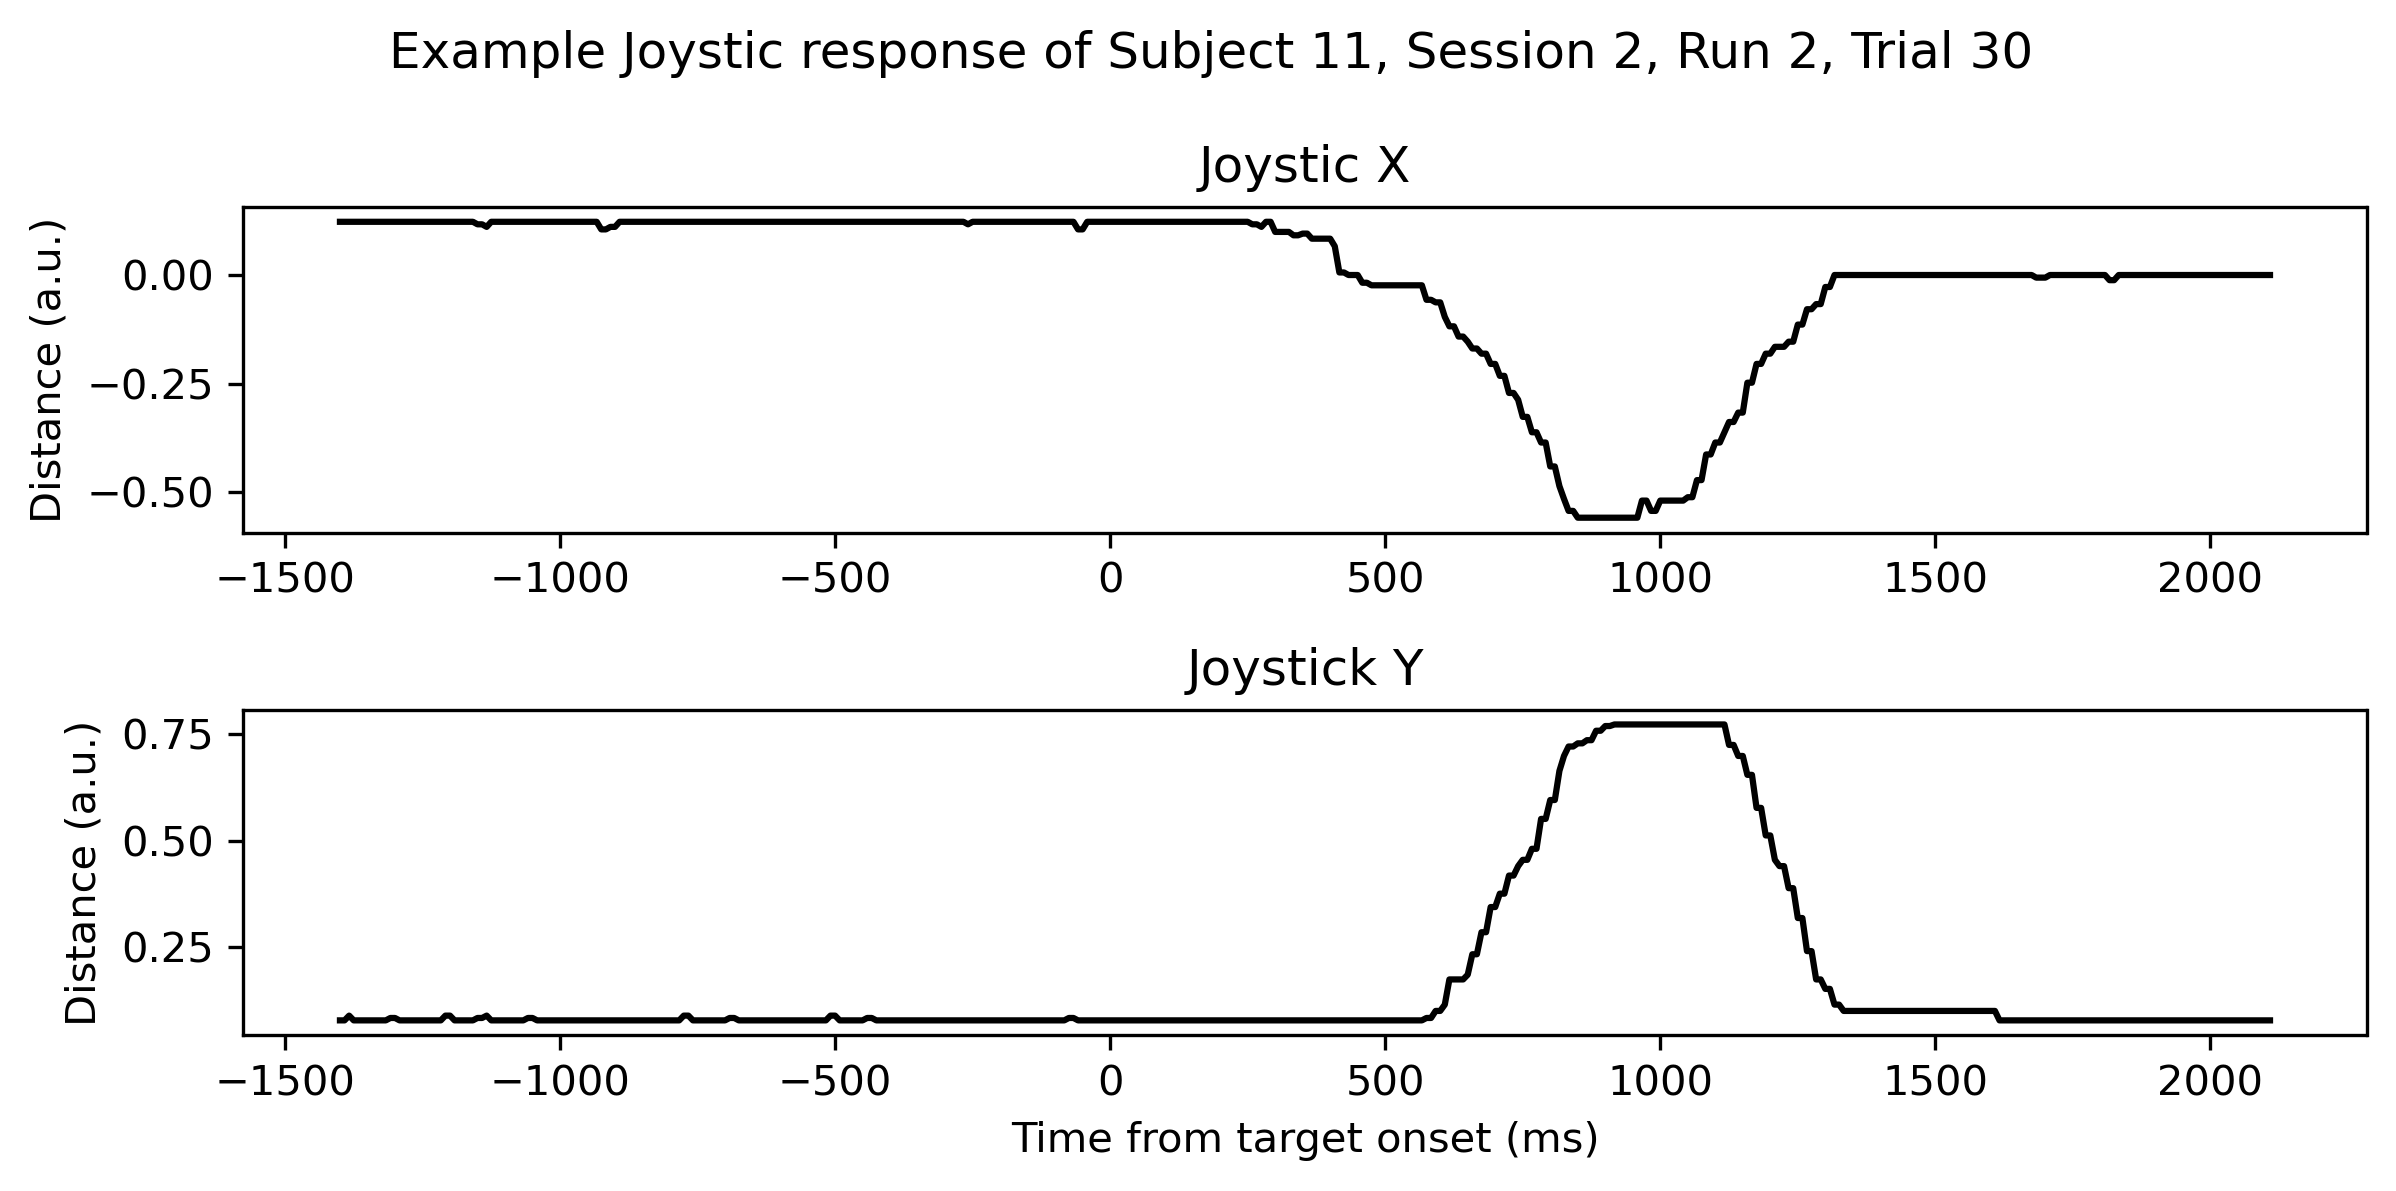

In [32]:
fr = 1000/120

fig, ax = plt.subplots(2, 1, figsize=(8, 4), dpi = 300)

ax[0].plot((np.array(range(-250, 750, 1))*fr)[:], shifted_jx[10,1,1,30], "-k")
ax[0].set_title("Joystic X")
ax[0].set_ylabel("Distance (a.u.)")

ax[1].plot((np.array(range(-250, 750, 1))*fr)[:], shifted_jy[10,1,1,30], "-k")
ax[1].set_title("Joystick Y")
ax[1].set_ylabel("Distance (a.u.)")
ax[1].set_xlabel("Time from target onset (ms)")

plt.suptitle("Example Joystic response of Subject 11, Session 2, Run 2, Trial 30")

plt.tight_layout()

In [10]:
final_resp_idx.shape, shifted_jx.shape, shifted_jy.shape, stimdir.shape

((13, 4, 6, 120),
 (13, 4, 6, 120, 1000),
 (13, 4, 6, 120, 1000),
 (13, 4, 6, 120))

In [11]:
vx = shifted_jx.reshape(13, 4*6*120, 1000)
vy = shifted_jy.reshape(13, 4*6*120, 1000)
vid = final_resp_idx.reshape(13, 4*6*120)
vt = stimdir.reshape(13, 4*6*120)

In [12]:
def draw_sector(ax, angle, std_dev, radius=1, color='lightgray', alpha=1):
    # Calculate start and end angles for the sector
    start_angle = np.radians(angle - std_dev)
    end_angle = np.radians(angle + std_dev)
    
    # Generate points for the sector
    theta = np.linspace(start_angle, end_angle, 100)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    
    # Fill the sector area starting from (0,0) to create a wedge
    ax.fill(np.concatenate([[0], x]), np.concatenate([[0], y]), color="#b2c5db", alpha=alpha)

    # Add markers at the start and end points of the arc
    ax.plot([x[0], x[-1]], [y[0], y[-1]], 'o', color='green', markersize=10, alpha=0.5, label="2$\sigma$ Margins") 

    # Convert angle to radians
    angle_radians = np.radians(angle)
    
    # Calculate the x and y coordinates for the endpoint
    x = np.cos(angle_radians)
    y = np.sin(angle_radians)

    circle = plt.Circle((0, 0), 1, color='lightgray', fill=False, linestyle='--')
    ax.add_artist(circle)
    
    # Plot the line on the given axis
    ax.plot([0, x], [0, y], c="#7485C2", linestyle="-", marker="o", linewidth=2, markersize=10, label="Calibrated Target")


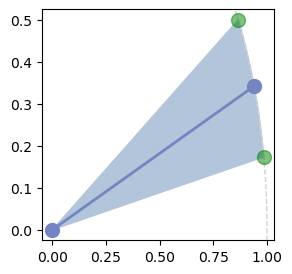

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))

draw_sector(axes, 20, 10)

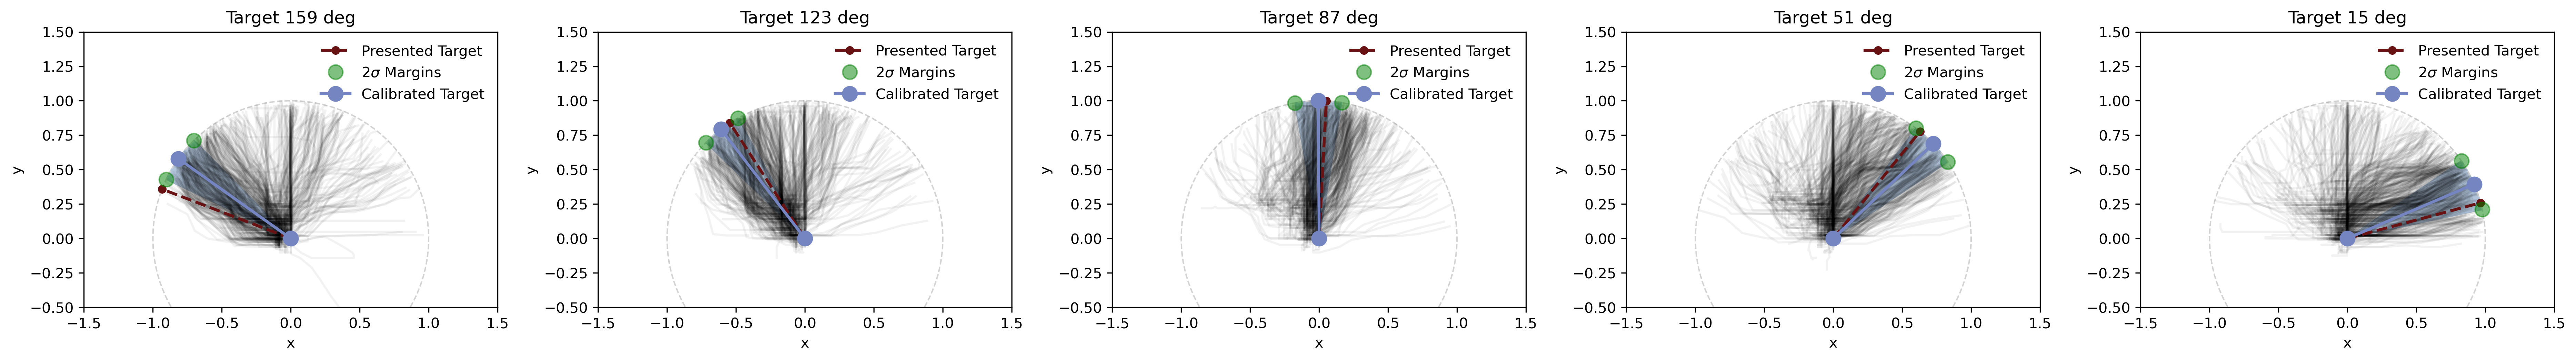

In [58]:
# Main plotting code
for sub in range(1):
    sub = 9
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), dpi=300)  # 1 row, 5 columns

    for i, ax in enumerate(axes):
        target_angle = experiment_orientations[i]
        mask = vt[sub] == target_angle

        vid_sub = vid[sub][mask]
        
        xd = vx[sub][mask]
        yd = vy[sub][mask]

        for i in range(len(xd)):
            ax.plot(xd[i][250:vid_sub[i]], yd[i][250:vid_sub[i]], c="k", alpha=0.05)
        
        # Plot scatter data
        ax.set_title(f'Target {target_angle} deg')
        
        # Putting the origianl target angle
        cx = np.cos(np.radians(target_angle))
        cy = np.sin(np.radians(target_angle))
        ax.plot([0, cx], [0, cy], c="#681213", linestyle="--", marker=".", linewidth=2, markersize=10, label="Presented Target")
        # Draw line for target angle
        draw_sector(ax, calib_median[sub,median_key[target_angle]], calib_std[subj,std_key[target_angle]])


        # Set title and limits
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-0.5, 1.5)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
        # legend without background
        ax.legend(loc='upper right', frameon=False)

    # Set aspect ratio for all plots in the row
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.suptitle(f"Subject {sub+1} (Runs)")
    plt.tight_layout()
    plt.show()


## Figure recreations

In [33]:
# get error angle over time

calib_error_angle = np.zeros_like(resp_angle)
calib_error_angle[:] = np.nan

for sub in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                t = stimdir[sub,sess,run,trial]
                a = calib_median[sub,median_key[t]]
                for ts in range(n_ts):
                    if np.isnan(resp_angle[sub,sess,run,trial,ts]):continue
                    b = resp_angle[sub,sess,run,trial,ts]
                    calib_error_angle[sub,sess,run,trial,ts] = circdist(a,b)

### Attention and coherence

In [34]:
att.shape, coh.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [35]:
foc_err = calib_error_angle[np.where(att == 1)]
div_err = calib_error_angle[np.where(att == 2)]

lo_err = calib_error_angle[np.where(coh == 1)]
hi_err = calib_error_angle[np.where(coh == 2)]

/tmp/ipykernel_3584093/732924122.py:8: RuntimeWarning: Mean of empty slice
  plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(foc_err, axis=(0))[:], 'c-')
/tmp/ipykernel_3584093/732924122.py:9: RuntimeWarning: Mean of empty slice
  plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(div_err, axis=(0))[:], 'c--')


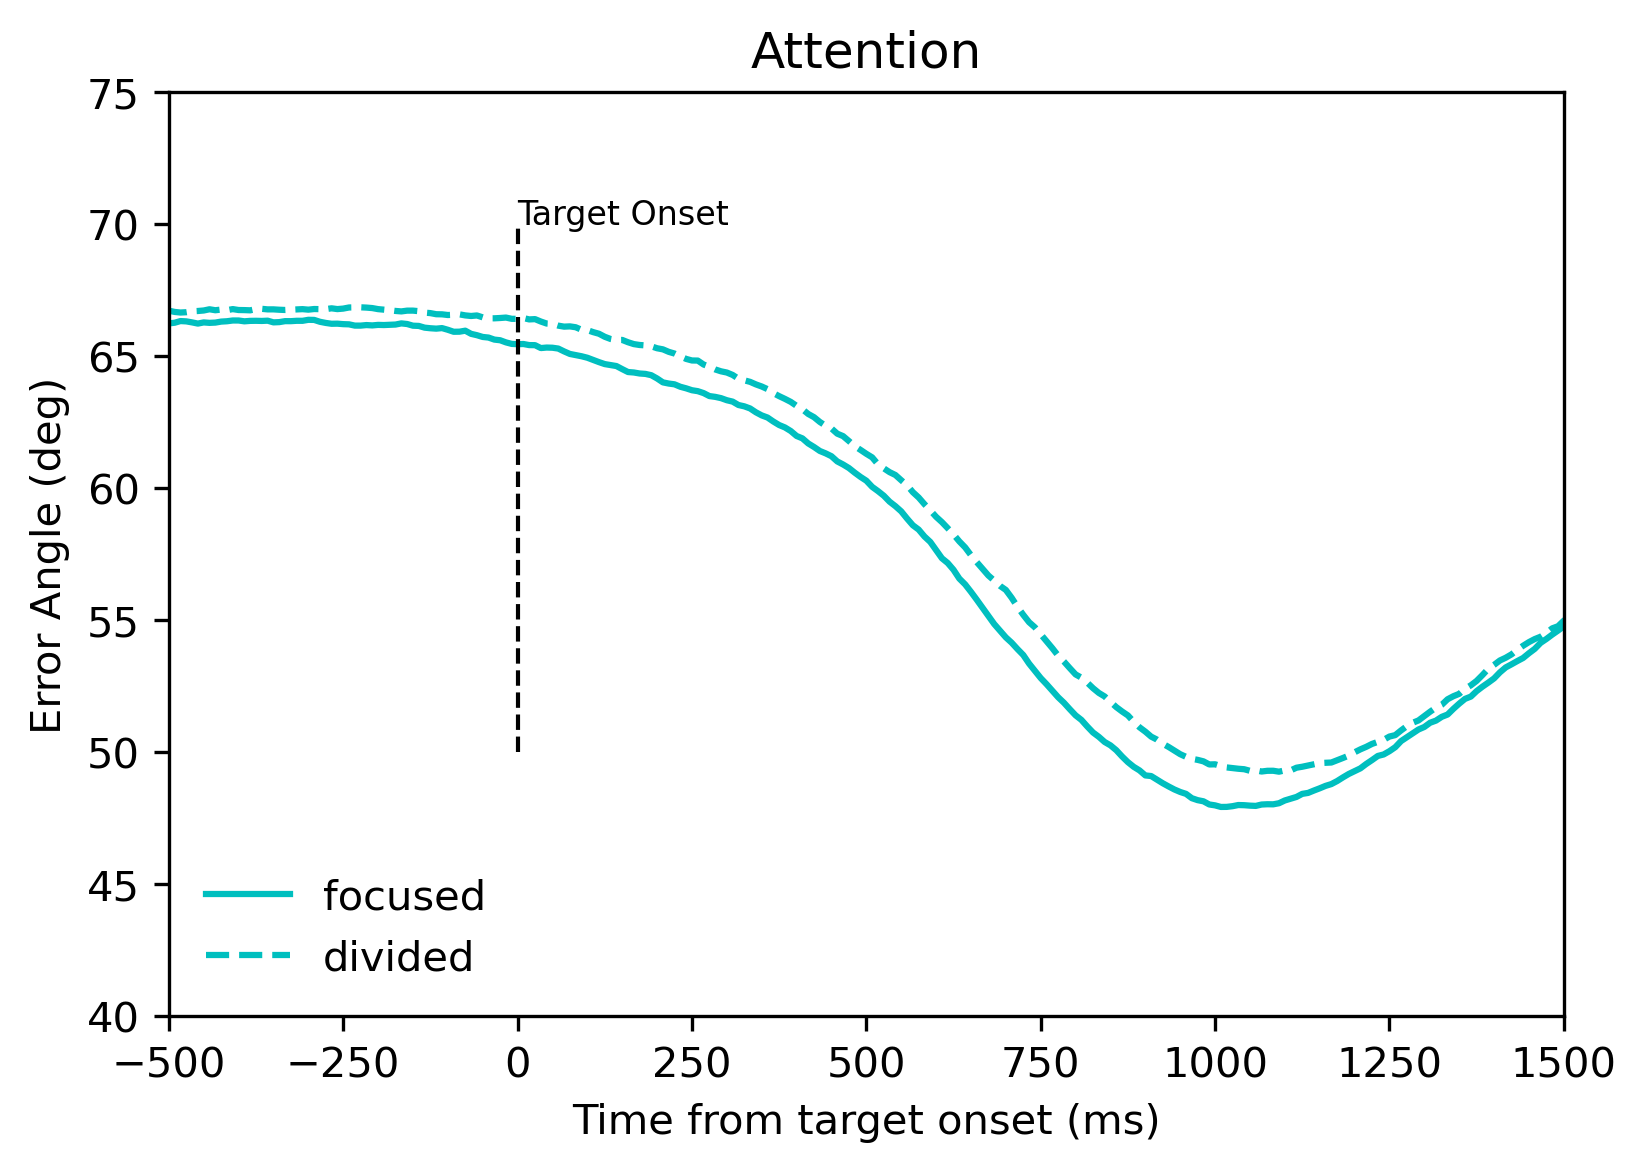

In [36]:
# Take the erros and mean across trials

x_crop = 150

fr = 1000/120

plt.figure(figsize=(6, 4), dpi=300)
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(foc_err, axis=(0))[:], 'c-')
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(div_err, axis=(0))[:], 'c--')
plt.xlabel('Time from target onset (ms)')
plt.ylabel('Error Angle (deg)')
plt.title('Attention')

plt.legend(['focused', 'divided'], loc='lower left', frameon=False)

plt.ylim(40, 75)
plt.xlim(-500, 1500)

# Add note that 0 is the point of target onset
plt.plot([0, 0], [50, 70], 'k--', lw=1)
plt.text(0, 70, 'Target Onset', fontsize=8)

plt.show()

/tmp/ipykernel_3584093/3026930331.py:8: RuntimeWarning: Mean of empty slice
  plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(hi_err, axis=(0))[:], 'k-')
/tmp/ipykernel_3584093/3026930331.py:9: RuntimeWarning: Mean of empty slice
  plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(lo_err, axis=(0))[:], 'k--')


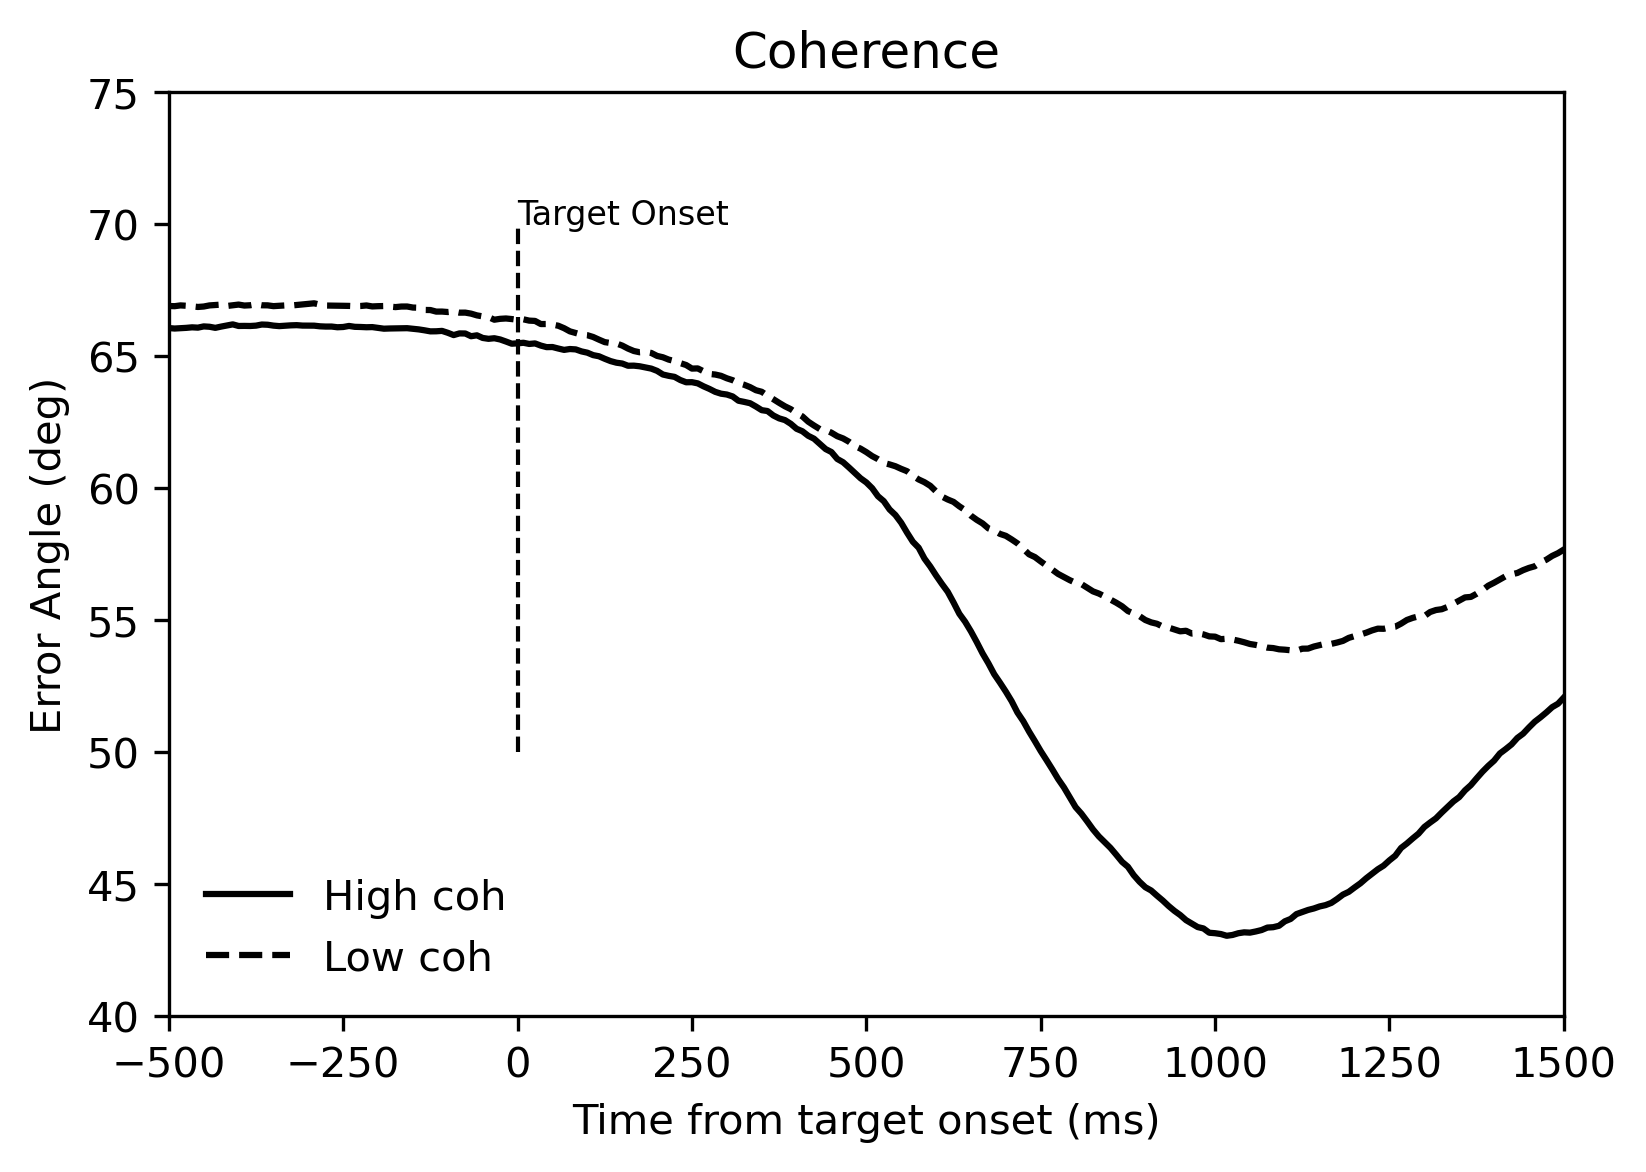

In [38]:
# Take the erros and mean across trials

x_crop = 150

fr = 1000/120

plt.figure(figsize=(6, 4), dpi=300)
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(hi_err, axis=(0))[:], 'k-')
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(lo_err, axis=(0))[:], 'k--')
plt.xlabel('Time from target onset (ms)')
plt.ylabel('Error Angle (deg)')
plt.title('Coherence')

plt.legend(['High coh', 'Low coh'], loc='lower left', frameon=False)

plt.ylim(40, 75)
plt.xlim(-500, 1500)

# Add note that 0 is the point of target onset
plt.plot([0, 0], [50, 70], 'k--', lw=1)
plt.text(0, 70, 'Target Onset', fontsize=8)

plt.show()

In [ ]:
# Take the erros and mean across trials

x_crop = 150

fr = 1000/120

plt.figure(figsize=(6, 4), dpi=300)
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(hi_err, axis=(0))[:], 'k-')
plt.plot((np.array(range(-250, 750, 1))*fr)[:], np.nanmean(lo_err, axis=(0))[:], 'k--')
plt.xlabel('Time from target onset (ms)')
plt.ylabel('Error Angle (deg)')
plt.title('Coherence')

plt.legend(['High coh', 'Low coh'], loc='lower left', frameon=False)

plt.ylim(40, 75)
plt.xlim(-500, 1500)

# Add note that 0 is the point of target onset
plt.plot([0, 0], [50, 70], 'k--', lw=1)
plt.text(0, 70, 'Target Onset', fontsize=8)

plt.show()

## Accuracy and performance

In [14]:
final_resp_angles.shape, stimdir.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [30]:
# One and two sigma distance from the calibration median

resp_correct_sigma = np.zeros_like(final_resp_angles)
resp_correct_sigma[:] = np.nan

resp_correct_two_sigma = np.zeros_like(final_resp_angles)
resp_correct_two_sigma[:] = np.nan

for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                actual_stimdir = stimdir[subj,sess,run,trial]

                # Get the median and std for the actual stimdir
                calib_resp_median = calib_median[subj,median_key[actual_stimdir]]
                calib_resp_sigma = calib_std[subj,std_key[actual_stimdir]]

                # Get the response angle
                trial_response = final_resp_angles[subj,sess,run,trial]

                # Skip if the trial is 'too early'
                if np.isnan(trial_response): continue

                # Check if the response is within 1 sigma or 2 sigma
                resp_correct_sigma[subj,sess,run,trial] = circdist(calib_resp_median, trial_response) <= calib_resp_sigma
                resp_correct_two_sigma[subj,sess,run,trial] = circdist(calib_resp_median, trial_response) <= calib_resp_sigma*2


In [16]:
resp_correct_sigma[0].flatten().shape

(2880,)

In [17]:
np.nansum(resp_correct_sigma[0])

574.0

In [18]:
574.0/2880*100

19.930555555555557

In [19]:
final_resp_angles.flatten().shape, final_resp_angles.shape

((37440,), (13, 4, 6, 120))

In [20]:
acc_result = np.zeros((n_subjects, 4))

for subj in range(n_subjects):
    acc_result[subj, 0] = np.nanmean(resp_correct_sigma[subj]) * 100
    acc_result[subj, 1] = np.nanmean(resp_correct_two_sigma[subj]) * 100
    acc_result[subj, 2] = np.unique(resp_correct_sigma[subj], return_counts=True)[1][-1]
    acc_result[subj, 3] = (np.unique(resp_correct_sigma[subj], return_counts=True)[1][-1]/2880) * 100

In [21]:
acc_df = pd.DataFrame(acc_result, columns=['1 sigma', '2 sigma', 'too early', 'too early %'])
acc_df.index = subjects
acc_df.round(2)

,1 sigma,2 sigma,too early,too early %
01,21.70,33.27,235.0,8.16
02,44.29,64.52,19.0,0.66
03,26.21,41.53,183.0,6.35
04,20.40,33.20,37.0,1.28
05,35.84,49.93,743.0,25.80
06,32.96,55.35,4.0,0.14
07,24.90,37.22,5.0,0.17
08,15.45,26.31,1352.0,46.94
09,27.67,38.50,119.0,4.13
10,43.93,68.00,89.0,3.09


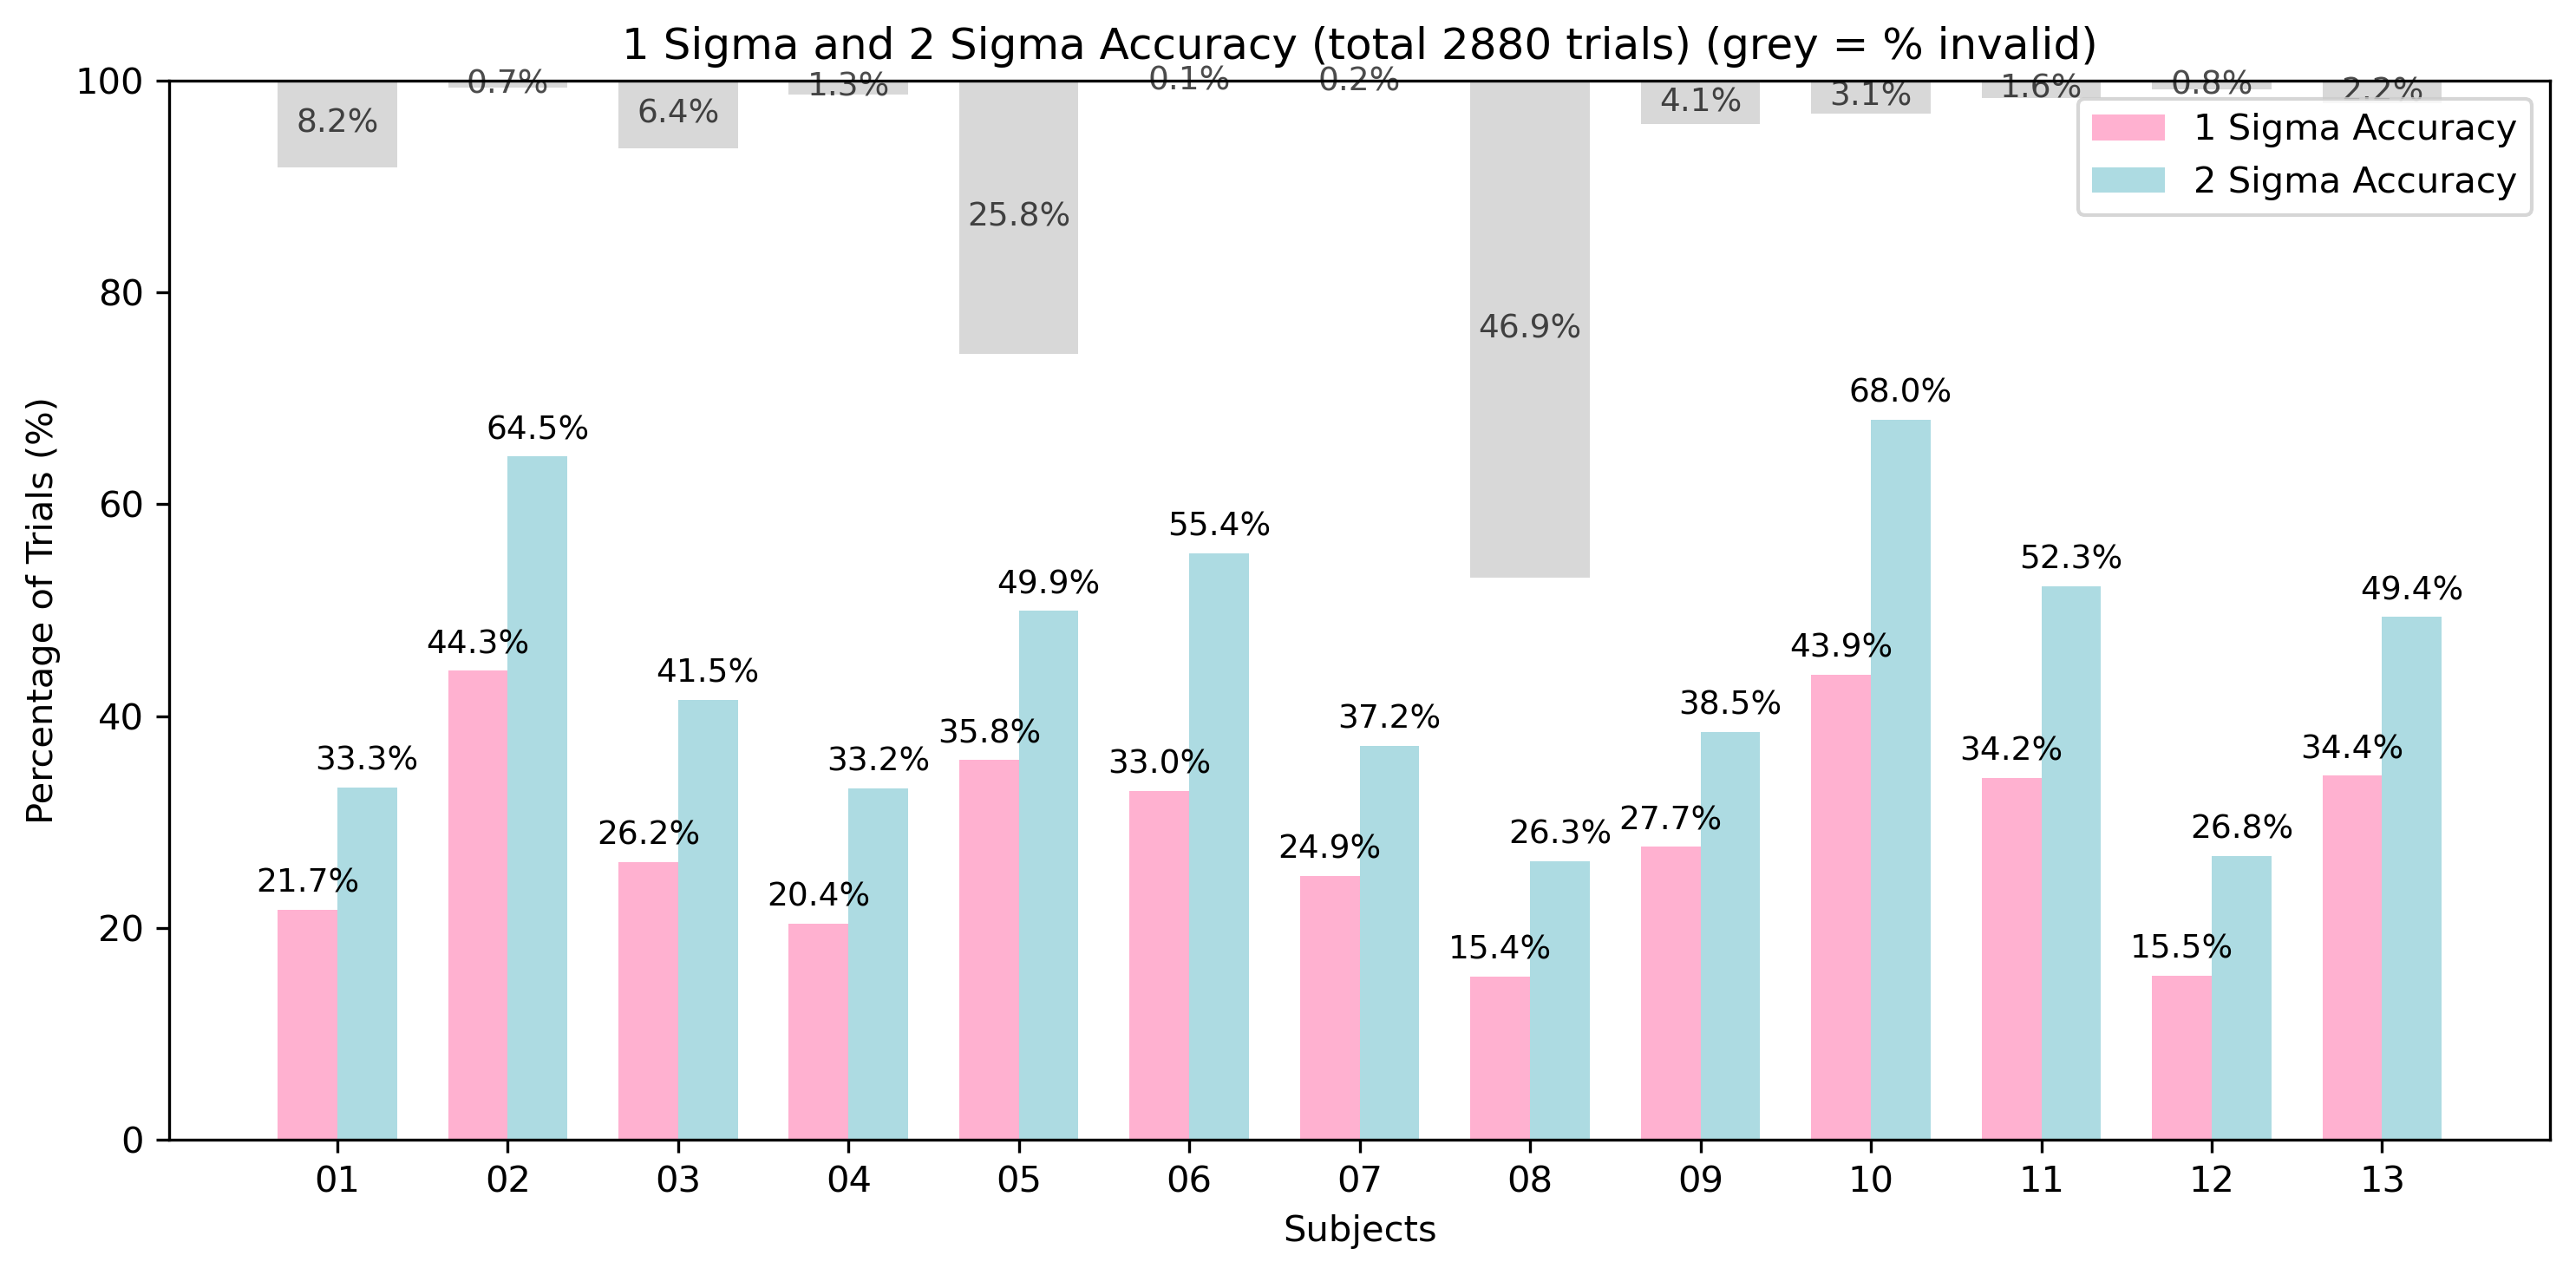

In [29]:
# Plotting with numbers on the bars
fig, ax = plt.subplots(figsize=(10, 5), dpi = 300)

bar_width = 0.35
x = np.arange(len(subjects))

# Bars for 1 sigma and 2 sigma percentages
bars_1_sigma = ax.bar(x - bar_width / 2, acc_df['1 sigma'], bar_width, label='1 Sigma Accuracy', color='#FF90BC', alpha=0.7)
bars_2_sigma = ax.bar(x + bar_width / 2, acc_df['2 sigma'], bar_width, label='2 Sigma Accuracy', color='#8ACDD7', alpha=0.7)

# Overlay gray segments for 'too early' trials from the top
for idx, subject in enumerate(subjects):
    ax.bar(idx - bar_width / 2, acc_df['too early %'][subject], bottom=100 - acc_df['too early %'][subject], color='gray', alpha=0.3, width=bar_width)
    ax.bar(idx + bar_width / 2, acc_df['too early %'][subject], bottom=100 - acc_df['too early %'][subject], color='gray', alpha=0.3, width=bar_width)

# Adding text labels on the bars for 1 sigma and 2 sigma
for bar in bars_1_sigma:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

for bar in bars_2_sigma:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Adding text labels for 'too early' on top
for idx, subject in enumerate(subjects):
    too_early_height = acc_df['too early %'][subject]
    total_height = 100
    ax.text(
        idx,
        total_height - too_early_height / 2,
        f'{too_early_height:.1f}%',
        ha='center',
        va='center',
        fontsize=9,
        color='black',
        alpha=0.7
    )

# Labeling
ax.set_xlabel('Subjects')
ax.set_ylabel('Percentage of Trials (%)')
ax.set_title('1 Sigma and 2 Sigma Accuracy (total 2880 trials) (grey = % invalid)')
ax.set_xticks(x)
ax.set_xticklabels(subjects)
ax.set_ylim(0, 100)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


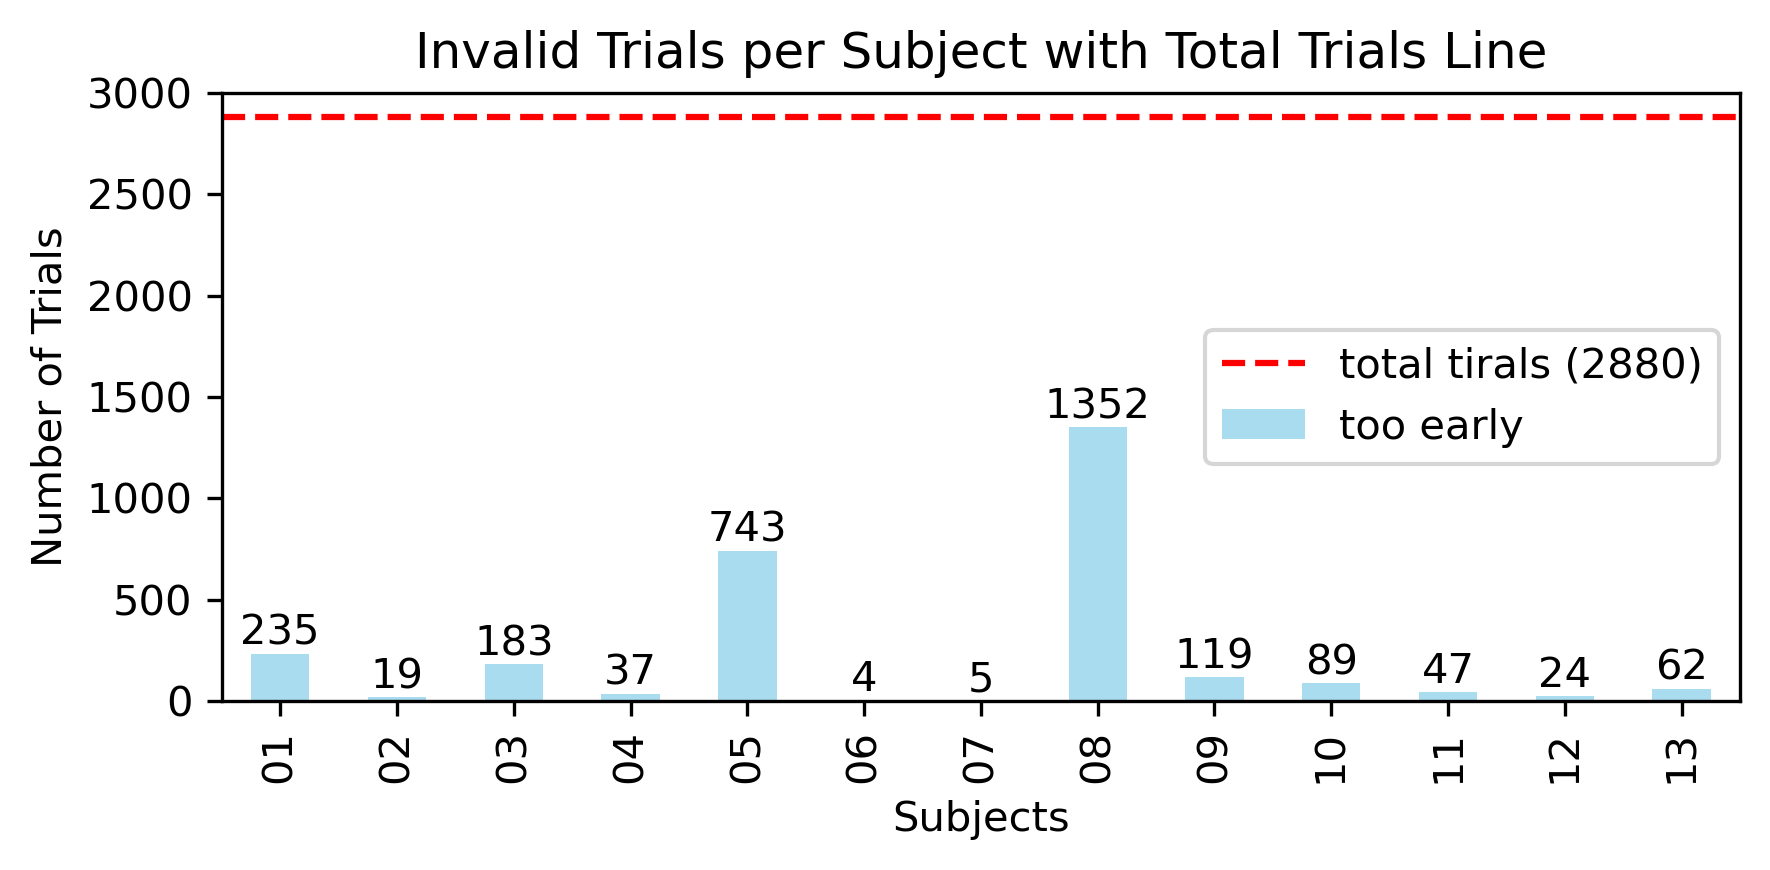

In [23]:
# Creating the bar plot for "too early" trials with a line at 2880
fix = plt.figure(dpi=300, figsize=(6,3))

# Plotting "too early" values for each subject
ax = acc_df["too early"].plot.bar(color='skyblue', alpha=0.7)
ax.bar_label(ax.containers[0])

# Adding a horizontal line at 2880
plt.axhline(y=2880, color='red', linestyle='--', linewidth=1.5, label='total tirals (2880)')

# Setting y-axis limits and labels
plt.ylim(0, 3000)
plt.xlabel('Subjects')
plt.ylabel('Number of Trials')
plt.title('Invalid Trials per Subject with Total Trials Line')
plt.legend()

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Accuracy (%)')

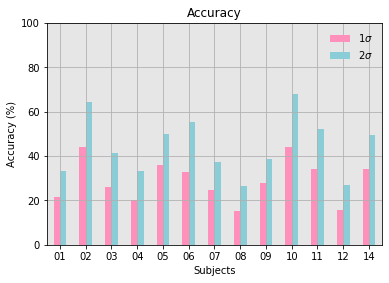

In [44]:
# barplot only columns 1 sigma and 2 sigma
# #FF90BC, #FFC0D9, #F9F9E0, #8ACDD7

fig = plt.figure(figsize=(6, 4), dpi=72)

ax = acc_df.iloc[:, :2].plot.bar(rot= 0,legend=True, title='Accuracy', ylim=(0, 100), color=['#FF90BC', '#8ACDD7'], grid=True, ax = plt.gca())

ax.set_facecolor('0.90')
ax.legend([r"1$\sigma$", r"2$\sigma$"],loc='upper right', frameon=False)
ax.set_xlabel("Subjects")
ax.set_ylabel("Accuracy (%)")


In [45]:
acc_df.round(2)

,1 sigma,2 sigma,too early
01,21.70,33.27,235.0
02,44.29,64.52,19.0
03,26.07,41.49,183.0
04,20.40,33.20,37.0
05,35.84,49.93,743.0
06,32.96,55.35,4.0
07,24.90,37.22,5.0
08,15.45,26.31,1352.0
09,27.67,38.50,119.0
10,43.93,68.00,89.0


## Expected only

In [115]:
final_resp_angles.shape, stimdir.shape

((13, 4, 6, 120), (13, 4, 6, 120))

In [134]:
# One and two sigma distance from the calibration median

resp_correct_sigma = np.zeros_like(final_resp_angles)
resp_correct_sigma[:] = np.nan

resp_correct_two_sigma = np.zeros_like(final_resp_angles)
resp_correct_two_sigma[:] = np.nan

for subj in range(n_subjects):
    for sess in range(1):
        for run in range(n_runs):
            for trial in range(n_trials):
                actual_stimdir = stimdir[subj,1,run,trial]

                # Get the median and std for the actual stimdir
                calib_resp_median = calib_median[subj,median_key[actual_stimdir]]
                calib_resp_sigma = calib_std[subj,std_key[actual_stimdir]]

                # Get the response angle
                trial_response = final_resp_angles[subj,sess,run,trial]

                # Skip if the trial is 'too early'
                if np.isnan(trial_response): continue

                # Check if the response is within 1 sigma or 2 sigma
                resp_correct_sigma[subj,sess,run,trial] = abs(circdist(calib_resp_median, trial_response)) <= calib_resp_sigma
                resp_correct_two_sigma[subj,sess,run,trial] = abs(circdist(calib_resp_median, trial_response)) <= calib_resp_sigma*2


In [135]:
unexp_sig = resp_correct_sigma[:,0,:,:]
unexp_two_sig = resp_correct_two_sigma[:,0,:,:]

In [136]:
np.unique(stimdir[:,0,:,:], return_counts=True)

(array([ 15,  51,  87, 123, 159], dtype=uint8),
 array([1872, 1872, 1872, 1872, 1872]))

In [137]:
unexp_tg = stimdir[:,0,:]

In [138]:
acc_result = np.zeros((n_subjects, 4))

for subj in range(n_subjects):
    acc_result[subj, 0] = np.nanmean(unexp_sig[subj]) * 100
    acc_result[subj, 1] = np.nanmean(unexp_two_sig[subj]) * 100
    acc_result[subj, 2] = np.unique(unexp_sig[subj], return_counts=True)[1][-1]
    acc_result[subj, 3] = (np.unique(unexp_sig[subj], return_counts=True)[1][-1]/480) * 100

In [139]:
acc_df = pd.DataFrame(acc_result, columns=['1 sigma', '2 sigma', 'too early', 'too early %'])
acc_df.index = subjects
acc_df.round(2)

,1 sigma,2 sigma,too early,too early %
01,11.61,21.43,8.0,1.67
02,32.20,53.39,2.0,0.42
03,21.74,39.13,5.0,1.04
04,19.33,32.77,1.0,0.21
05,7.61,13.04,28.0,5.83
06,16.67,33.33,20.0,4.17
07,12.50,30.00,15.0,3.12
08,12.24,18.37,71.0,14.79
09,22.77,32.67,19.0,3.96
10,19.33,50.42,1.0,0.21


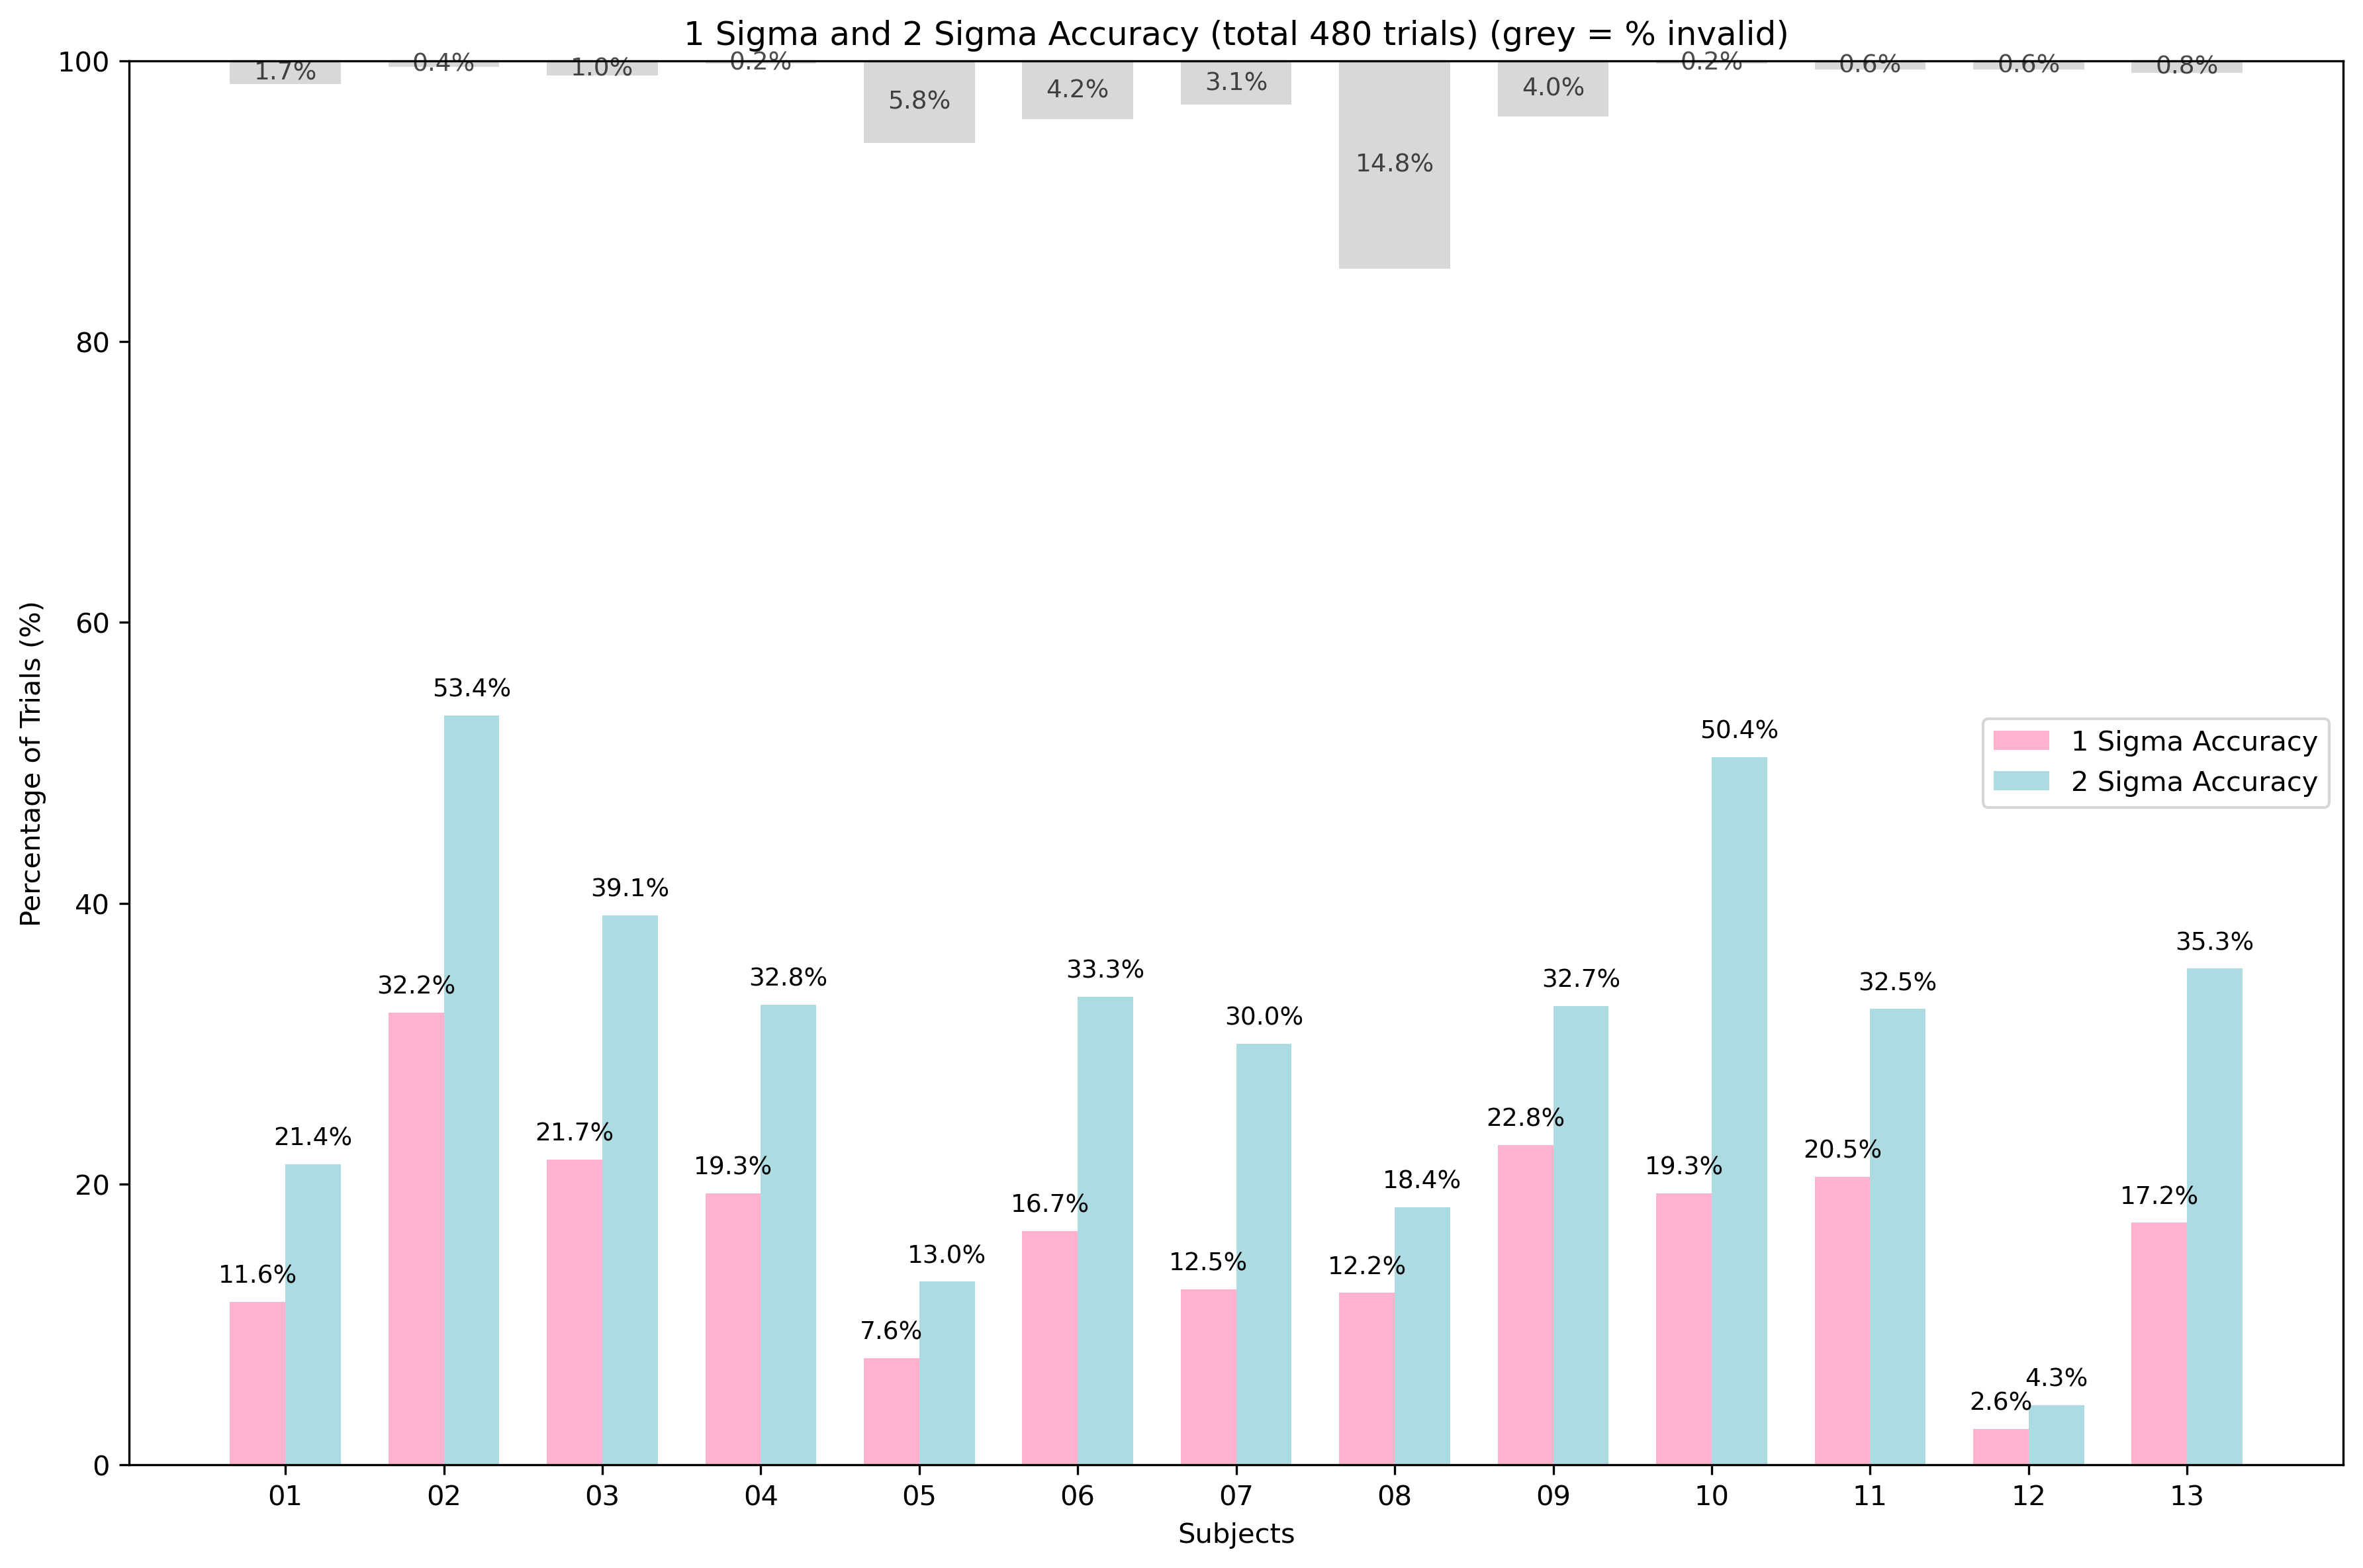

In [140]:
# Plotting with numbers on the bars
fig, ax = plt.subplots(figsize=(12, 8), dpi = 300)

bar_width = 0.35
x = np.arange(len(subjects))

# Bars for 1 sigma and 2 sigma percentages
bars_1_sigma = ax.bar(x - bar_width / 2, acc_df['1 sigma'], bar_width, label='1 Sigma Accuracy', color='#FF90BC', alpha=0.7)
bars_2_sigma = ax.bar(x + bar_width / 2, acc_df['2 sigma'], bar_width, label='2 Sigma Accuracy', color='#8ACDD7', alpha=0.7)

# Overlay gray segments for 'too early' trials from the top
for idx, subject in enumerate(subjects):
    ax.bar(idx - bar_width / 2, acc_df['too early %'][subject], bottom=100 - acc_df['too early %'][subject], color='gray', alpha=0.3, width=bar_width)
    ax.bar(idx + bar_width / 2, acc_df['too early %'][subject], bottom=100 - acc_df['too early %'][subject], color='gray', alpha=0.3, width=bar_width)

# Adding text labels on the bars for 1 sigma and 2 sigma
for bar in bars_1_sigma:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

for bar in bars_2_sigma:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Adding text labels for 'too early' on top
for idx, subject in enumerate(subjects):
    too_early_height = acc_df['too early %'][subject]
    total_height = 100
    ax.text(
        idx,
        total_height - too_early_height / 2,
        f'{too_early_height:.1f}%',
        ha='center',
        va='center',
        fontsize=9,
        color='black',
        alpha=0.7
    )

# Labeling
ax.set_xlabel('Subjects')
ax.set_ylabel('Percentage of Trials (%)')
ax.set_title('1 Sigma and 2 Sigma Accuracy (total 480 trials) (grey = % invalid)')
ax.set_xticks(x)
ax.set_xticklabels(subjects)
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()
plt.show()


In [141]:
np.unique(unexp_sig, return_counts=True)

(array([ 0.,  1., nan]), array([6896, 1733,  731]))

In [142]:
unexp_sig[0].flatten().shape

(720,)

In [143]:
38/480*100

7.916666666666666

In [144]:
439/unexp_sig.flatten().shape[0] * 100

4.69017094017094